In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

columns1 = inspector.get_columns('measurement')
columns2 = inspector.get_columns('station')
for c in columns1:
    print(c['name'], c['type'])
print('-----')
for d in columns2:
    print(d['name'], d['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
date_threshold = dt.datetime(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
measurement_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > date_threshold).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_dates = [result[0] for result in measurement_data]
measurement_prcps = [result[1] for result in measurement_data]

precipitation_df = pd.DataFrame(measurement_data, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index(ascending=True)
precipitation_df = precipitation_df.fillna(0)
precipitation_df

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,0.00
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


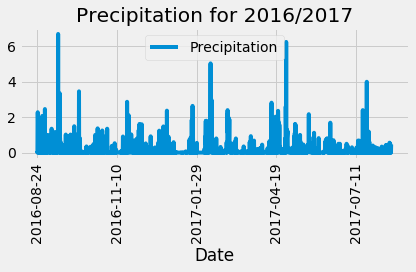

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title='Precipitation for 2016/2017', rot=90)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(f"The mean precipitation is {precipitation_df['Precipitation'].mean()}.")
print(f"The median precipitation is {precipitation_df['Precipitation'].median()}.")
print(f"The total precipitation is {precipitation_df['Precipitation'].sum()}.")

The mean precipitation is 0.15995051731893775.
The median precipitation is 0.01.
The total precipitation is 355.57.


In [13]:
# Design a query to show how many stations are available in this dataset?

station_data = session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_count = session.query(Station.station).count()
print(f"There are {station_count} stations in the dataset.")


There are 9 stations in the dataset.


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_groups = session.query(func.count(Measurement.id), Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
station_groups

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [15]:
print(f"The most active station is {station_groups[0]}.")

The most active station is (2772, 'USC00519281').


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_temp = session.query(func.min(Measurement.tobs)).one()
print(f"The minimum temperature observed is {min_temp}.")
max_temp = session.query(func.max(Measurement.tobs)).one()
print(f"The maximum temperature observed is {max_temp}.")
avg_temp = session.query(func.avg(Measurement.tobs)).one()
print(f"The average temperature observed is {avg_temp}.")


The minimum temperature observed is (53.0,).
The maximum temperature observed is (87.0,).
The average temperature observed is (73.09795396419437,).


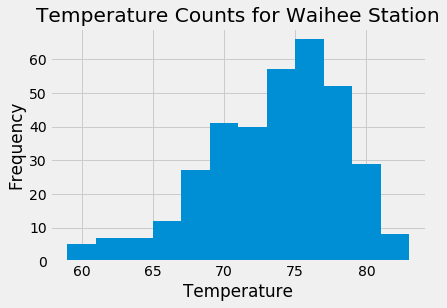

In [17]:
# Choose the station with the highest number of temperature observations.
# This is USC00519281.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
particular_station_data = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date > date_threshold).all()
temps = [result[0] for result in particular_station_data]
plt.hist(temps, bins=12)
plt.title("Temperature Counts for Waihee Station")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()



## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2016-08-24', '2017-08-23'))


[(58.0, 74.57894736842105, 87.0)]


In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
year_min = [result[0] for result in calc_temps('2016-08-24', '2017-08-23')]
year_max = [result[1] for result in calc_temps('2016-08-24', '2017-08-23')]
year_avg = [result[2] for result in calc_temps('2016-08-24', '2017-08-23')]
print(year_min)
print(year_max)
print(year_avg)

[58.0]
[74.57894736842105]
[87.0]


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
